In [5]:
import numpy as np
import matplotlib.pyplot as plt

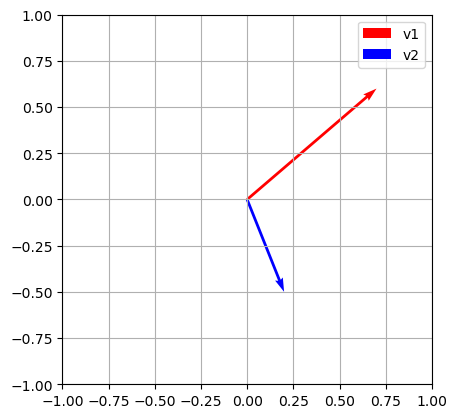

In [6]:
# Create two 2D basis vectors
v1 = np.array([0.7, 0.6])
v2 = np.array([0.2, -0.5])

# Plot vectors
fig, ax = plt.subplots()
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='r', label='v1')
ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='b', label='v2')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid()
ax.legend()
plt.show()

Scanline method: 648 points


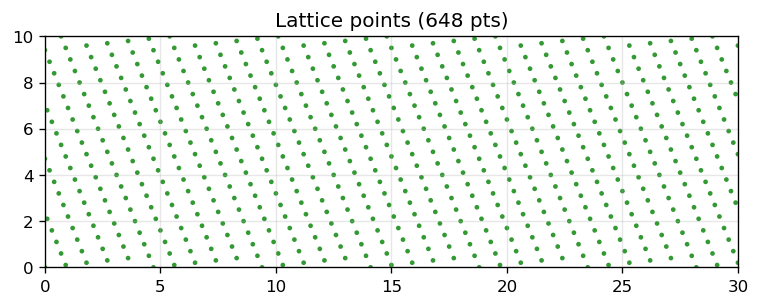

In [12]:
# Define the area to fill
width, height = 30.0, 10.0

def fill_area_with_lattice_points(v1, v2, width, height, eps=1e-12):
    """
    Fill a rectangle [0, width) x [0, height) with lattice points using scanline algorithm.
    
    Translates the Rust scanline method: transform the rectangle corners to lattice coordinates,
    find the bounding box in index space, then enumerate all integer lattice indices and
    reject those outside the rectangle.
    
    Args:
        v1, v2: 2D basis vectors (array-like)
        width, height: rectangle dimensions
        eps: tolerance for boundary inclusion
    
    Returns:
        Array of 2D points inside the rectangle
    """
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    
    # Build basis matrix B (columns are v1, v2) and its inverse
    B = np.column_stack([v1, v2])
    try:
        Binv = np.linalg.inv(B)
    except np.linalg.LinAlgError:
        return np.array([])  # degenerate basis
    
    # Transform the 4 corners of the rectangle to lattice coordinates (k-space)
    corners = np.array([
        [0.0, 0.0],
        [0.0, height],
        [width, 0.0],
        [width, height]
    ])
    
    uv_corners = corners @ Binv.T  # shape (4, 2)
    
    # Find bounding box in lattice index space
    umin = uv_corners[:, 0].min()
    umax = uv_corners[:, 0].max()
    vmin = uv_corners[:, 1].min()
    vmax = uv_corners[:, 1].max()
    
    # Expand by 1 to ensure we don't miss boundary points
    u_lo = int(np.floor(umin)) - 1
    u_hi = int(np.ceil(umax)) + 1
    v_lo = int(np.floor(vmin)) - 1
    v_hi = int(np.ceil(vmax)) + 1
    
    # Enumerate all integer lattice points in the bounding box
    out = []
    for m in range(u_lo, u_hi + 1):
        for n in range(v_lo, v_hi + 1):
            # Transform back to real space: x = B * [m, n]
            x = B @ np.array([m, n], dtype=float)
            # Check if inside rectangle with tolerance
            if (x[0] >= -eps and x[0] <= width + eps and
                x[1] >= -eps and x[1] <= height + eps):
                out.append(x)
    
    return np.array(out)

lattice_points = fill_area_with_lattice_points(v1, v2, width, height)

print(f"Scanline method: {len(lattice_points)} points")

# Plot the lattice points within the rectangle
dpi = 120
fig_w = max(4.0, min(12.0, width / 4.0))
fig_h = max(2.0, min(8.0, height / 4.0))
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
ax.scatter(lattice_points[:, 0], lattice_points[:, 1], color='g', s=8, alpha=0.8, edgecolors='none')
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)
ax.set_title(f"Lattice points ({len(lattice_points)} pts)")
plt.show()

In [13]:
# Brute force enumeration to validate counts
max_idx = 200
indices = []
for i in range(-max_idx, max_idx + 1):
    for j in range(-max_idx, max_idx + 1):
        point = i * v1 + j * v2
        if 0 <= point[0] < width and 0 <= point[1] < height:
            indices.append(point)

brute_points = np.array(indices)
print(f"brute-force: {len(brute_points)} points inside rectangle")

# Compare against torus-based result if available
if 'lattice_points' in locals():
    x_counts = len(np.unique(np.round(lattice_points[:, 0], 6)))
    y_counts = len(np.unique(np.round(lattice_points[:, 1], 6)))
    print(
        f"torus result diagnostics: total={len(lattice_points)}, unique_x={x_counts}, unique_y={y_counts}"
    )


brute-force: 637 points inside rectangle
torus result diagnostics: total=648, unique_x=301, unique_y=101


In [14]:
# Implement the AABB method (bounding-box with rejection)
def fill_area_aabb(v1, v2, xmin, xmax, ymin, ymax, eps=1e-12):
    """
    Fill axis-aligned bounding box [xmin, xmax] x [ymin, ymax] with lattice points.
    
    Translates the Rust points_in_aabb method: transform corners to lattice coordinates,
    enumerate integer indices in bounding box, reject points outside.
    
    Args:
        v1, v2: 2D basis vectors
        xmin, xmax, ymin, ymax: rectangle bounds
        eps: tolerance for boundary inclusion
    
    Returns:
        Array of 2D points inside the rectangle
    """
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    
    # Build basis matrix and inverse
    B = np.column_stack([v1, v2])
    try:
        Binv = np.linalg.inv(B)
    except np.linalg.LinAlgError:
        return np.array([])
    
    # Transform 4 corners to k-space
    corners = np.array([
        [xmin, ymin],
        [xmin, ymax],
        [xmax, ymin],
        [xmax, ymax]
    ])
    
    uv_corners = corners @ Binv.T
    
    # Find bounding box in index space
    umin = uv_corners[:, 0].min()
    umax = uv_corners[:, 0].max()
    vmin = uv_corners[:, 1].min()
    vmax = uv_corners[:, 1].max()
    
    u_lo = int(np.floor(umin)) - 1
    u_hi = int(np.ceil(umax)) + 1
    v_lo = int(np.floor(vmin)) - 1
    v_hi = int(np.ceil(vmax)) + 1
    
    # Enumerate and reject
    out = []
    for m in range(u_lo, u_hi + 1):
        for n in range(v_lo, v_hi + 1):
            x = B @ np.array([m, n], dtype=float)
            if (x[0] >= xmin - eps and x[0] <= xmax + eps and
                x[1] >= ymin - eps and x[1] <= ymax + eps):
                out.append(x)
    
    return np.array(out)

# Test it matches the scanline result
aabb_points = fill_area_aabb(v1, v2, 0, width, 0, height)
print(f"AABB method: {len(aabb_points)} points")
print(f"Scanline method: {len(lattice_points)} points")
print(f"Match: {len(aabb_points) == len(lattice_points)}")

AABB method: 648 points
Scanline method: 648 points
Match: True


In [20]:
import time

# Benchmark setup: 500 x 100 rectangle
bench_width, bench_height = 600.0, 200.0

def benchmark_method(func, name, duration=2.0):
    """Run a function repeatedly for ~duration seconds and report average time."""
    count = 0
    start = time.perf_counter()
    
    while time.perf_counter() - start < duration:
        result = func()
        count += 1
    
    elapsed = time.perf_counter() - start
    avg_time_ms = (elapsed / count) * 1000
    points = len(result)
    
    print(f"{name:20s}: {count:5d} runs in {elapsed:.2f}s → {avg_time_ms:.4f} ms/run ({points} points)")
    return avg_time_ms, points

print(f"Benchmarking on {bench_width} x {bench_height} rectangle with basis v1={v1}, v2={v2}")
print("=" * 80)

# Brute force
def brute_bench():
    max_idx = 1000
    indices = []
    for i in range(-max_idx, max_idx + 1):
        for j in range(-max_idx, max_idx + 1):
            point = i * v1 + j * v2
            if 0 <= point[0] < bench_width and 0 <= point[1] < bench_height:
                indices.append(point)
    return np.array(indices)

# Scanline
def scanline_bench():
    return fill_area_with_lattice_points(v1, v2, bench_width, bench_height)

# AABB
def aabb_bench():
    return fill_area_aabb(v1, v2, 0, bench_width, 0, bench_height)

time_brute, pts_brute = benchmark_method(brute_bench, "Brute force", duration=2.0)
time_scanline, pts_scanline = benchmark_method(scanline_bench, "Scanline", duration=2.0)
time_aabb, pts_aabb = benchmark_method(aabb_bench, "AABB", duration=2.0)

print("=" * 80)
print(f"Speedup vs brute force:")
print(f"  Scanline: {time_brute / time_scanline:.2f}x faster")
print(f"  AABB:     {time_brute / time_aabb:.2f}x faster")

Benchmarking on 600.0 x 200.0 rectangle with basis v1=[0.7 0.6], v2=[ 0.2 -0.5]
Brute force         :     1 runs in 5.07s → 5068.5891 ms/run (255288 points)
Brute force         :     1 runs in 5.07s → 5068.5891 ms/run (255288 points)
Scanline            :     3 runs in 2.56s → 851.9771 ms/run (255489 points)
Scanline            :     3 runs in 2.56s → 851.9771 ms/run (255489 points)
AABB                :     3 runs in 2.61s → 870.1533 ms/run (255489 points)
Speedup vs brute force:
  Scanline: 5.95x faster
  AABB:     5.82x faster
AABB                :     3 runs in 2.61s → 870.1533 ms/run (255489 points)
Speedup vs brute force:
  Scanline: 5.95x faster
  AABB:     5.82x faster


Circle scanline method: 10680 points


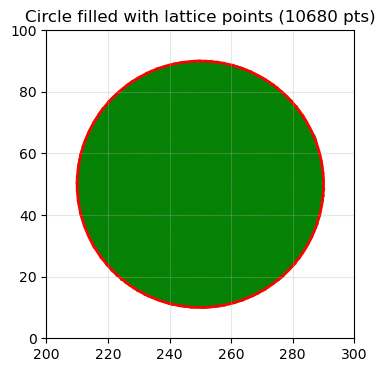

In [16]:
# Implement polygon scanline method for arbitrary convex polygons
def fill_area_polygon_scanline(v1, v2, polygon, eps=1e-12):
    """
    Fill a convex polygon with lattice points using scanline algorithm.
    
    Translates the Rust points_in_polygon_scanline method: transform polygon to lattice
    coordinates, scan integer u-lines, find v-intersections with edges, fill pairs.
    
    Args:
        v1, v2: 2D basis vectors
        polygon: List/array of 2D vertices in CCW order
        eps: tolerance for edge/intersection tests
    
    Returns:
        Array of 2D points inside the polygon
    """
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    polygon = np.array(polygon, dtype=float)
    
    assert len(polygon) >= 3, "Polygon must have at least 3 vertices"
    
    # Build basis matrix and inverse
    B = np.column_stack([v1, v2])
    try:
        Binv = np.linalg.inv(B)
    except np.linalg.LinAlgError:
        return np.array([])
    
    # Map polygon to k-space (lattice coordinates)
    kpoly = polygon @ Binv.T
    
    # Find integer u-range to scan
    umin = kpoly[:, 0].min()
    umax = kpoly[:, 0].max()
    u_lo = int(np.ceil(umin))
    u_hi = int(np.floor(umax))
    
    # Close polygon for edge loop
    kpoly_closed = np.vstack([kpoly, kpoly[0:1]])
    
    out = []
    for m in range(u_lo, u_hi + 1):
        u_line = float(m)
        v_hits = []
        
        # Intersect vertical line u = m with polygon edges
        for e in range(len(kpoly_closed) - 1):
            p0 = kpoly_closed[e]
            p1 = kpoly_closed[e + 1]
            
            # Skip horizontal-in-u edges (parallel to scanline)
            if abs(p1[0] - p0[0]) < eps:
                continue
            
            # Parametric intersection t with u = u_line
            t = (u_line - p0[0]) / (p1[0] - p0[0])
            if t >= -eps and t <= 1.0 + eps:
                v_hit = p0[1] + t * (p1[1] - p0[1])
                v_hits.append(v_hit)
        
        if len(v_hits) == 0:
            continue
        
        v_hits.sort()
        
        # Even-odd fill rule: take pairs
        for w in range(0, len(v_hits), 2):
            if w + 1 >= len(v_hits):
                break
            v0 = v_hits[w]
            v1 = v_hits[w + 1]
            
            # Fill integer n between the two intersections (inclusive)
            n_lo = int(np.ceil(v0))
            n_hi = int(np.floor(v1))
            
            for n in range(n_lo, n_hi + 1):
                x = B @ np.array([m, n], dtype=float)
                out.append(x)
    
    return np.array(out)

# Helper to generate circle polygon
def circle_polygon(center, radius, num_vertices=64):
    """Generate a circle as a polygon with given number of vertices (CCW order)."""
    angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    vertices = np.column_stack([
        center[0] + radius * np.cos(angles),
        center[1] + radius * np.sin(angles)
    ])
    return vertices

# Test on a circle
circle_center = [250.0, 50.0]
circle_radius = 40.0
circle_poly = circle_polygon(circle_center, circle_radius, num_vertices=64)

circle_points_scanline = fill_area_polygon_scanline(v1, v2, circle_poly)
print(f"Circle scanline method: {len(circle_points_scanline)} points")

# Visualize
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.scatter(circle_points_scanline[:, 0], circle_points_scanline[:, 1], 
           color='g', s=8, alpha=0.8, edgecolors='none')
circle_plot = plt.Circle(circle_center, circle_radius, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(circle_plot)
ax.set_xlim(circle_center[0] - circle_radius - 10, circle_center[0] + circle_radius + 10)
ax.set_ylim(circle_center[1] - circle_radius - 10, circle_center[1] + circle_radius + 10)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_title(f"Circle filled with lattice points ({len(circle_points_scanline)} pts)")
plt.show()

In [19]:
# Circle benchmark: compare brute force, AABB, and scanline
bench_circle_center = [250.0, 50.0]
bench_circle_radius = 100.0
bench_circle_poly = circle_polygon(bench_circle_center, bench_circle_radius, num_vertices=64)

def is_in_circle(point, center, radius):
    """Check if point is inside circle."""
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    return dx*dx + dy*dy <= radius*radius

# Brute force for circle
def brute_circle():
    max_idx = 500
    indices = []
    for i in range(-max_idx, max_idx + 1):
        for j in range(-max_idx, max_idx + 1):
            point = i * v1 + j * v2
            if is_in_circle(point, bench_circle_center, bench_circle_radius):
                indices.append(point)
    return np.array(indices)

# AABB for circle (bounding box of circle)
def aabb_circle():
    xmin = bench_circle_center[0] - bench_circle_radius
    xmax = bench_circle_center[0] + bench_circle_radius
    ymin = bench_circle_center[1] - bench_circle_radius
    ymax = bench_circle_center[1] + bench_circle_radius
    
    # Get all points in bounding box
    candidates = fill_area_aabb(v1, v2, xmin, xmax, ymin, ymax)
    
    # Filter to circle
    out = []
    for pt in candidates:
        if is_in_circle(pt, bench_circle_center, bench_circle_radius):
            out.append(pt)
    return np.array(out)

# Scanline for circle
def scanline_circle():
    return fill_area_polygon_scanline(v1, v2, bench_circle_poly)

print(f"Circle Benchmark: center={bench_circle_center}, radius={bench_circle_radius}")
print("=" * 80)

time_brute_c, pts_brute_c = benchmark_method(brute_circle, "Brute force", duration=2.0)
time_aabb_c, pts_aabb_c = benchmark_method(aabb_circle, "AABB + filter", duration=2.0)
time_scanline_c, pts_scanline_c = benchmark_method(scanline_circle, "Scanline", duration=2.0)

print("=" * 80)
print(f"Speedup vs brute force:")
print(f"  AABB + filter: {time_brute_c / time_aabb_c:.2f}x faster")
print(f"  Scanline:      {time_brute_c / time_scanline_c:.2f}x faster")
print(f"\nScanline vs AABB+filter: {time_aabb_c / time_scanline_c:.2f}x faster")

Circle Benchmark: center=[250.0, 50.0], radius=100.0
Brute force         :     2 runs in 2.77s → 1386.5831 ms/run (66844 points)
Brute force         :     2 runs in 2.77s → 1386.5831 ms/run (66844 points)
AABB + filter       :    10 runs in 2.18s → 217.7891 ms/run (66844 points)
AABB + filter       :    10 runs in 2.18s → 217.7891 ms/run (66844 points)
Scanline            :    29 runs in 2.01s → 69.4603 ms/run (66736 points)
Speedup vs brute force:
  AABB + filter: 6.37x faster
  Scanline:      19.96x faster

Scanline vs AABB+filter: 3.14x faster
Scanline            :    29 runs in 2.01s → 69.4603 ms/run (66736 points)
Speedup vs brute force:
  AABB + filter: 6.37x faster
  Scanline:      19.96x faster

Scanline vs AABB+filter: 3.14x faster
